# Saliancy Maps on the model "Accurate Spectral Super-Resolution from Single RGB Image Using Multi-scale CNN"
### It is a U-Net based model that takes an RGB image and outputs a 31 bands spectral image

## Initial code setup

In [1]:
import os
import cv2
import numpy as np
import torch
from torchvision import models
from IPython.display import Image
import torch.nn as nn
from torch.nn import ReLU
import matplotlib.pyplot as plt
from PIL import Image as PilImage


d:\Norway2.0\AAA\fastcam-master\envf\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Lets load things we need for **Grad-CAM**

In [3]:
from torchvision.utils import make_grid, save_image
import torch.nn.functional as F

from gradcam.utils import visualize_cam
from gradcam import GradCAMpp, GradCAM

# The GradCAM kit throws a warning we don't need to see for this demo. 
import warnings
warnings.filterwarnings('ignore')

Now we import the code for **this package**.

In [2]:
import maps
import mask
import draw
import norm
import misc

Importing for the other U-Net model package 

In [2]:
from model import Model # my model
from model_ref import Model_Ref # Fully Conv DenseNet
from utilities import *
import types

This is where we can set some parameters like the image name and the layer weights.

In [3]:
# input_image_name    = "ILSVRC2012_val_00049934.224x224.png"     # Our input image to process 
path = './testSet/' # path to the test input images

output_dir          = 'outputs2'                                 # Where to save our output images
input_dir           = 'images'                                  # Where to load our inputs from

weightsSR             = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]                 # Equal Weights work best 
                                                                # when using with GradCAM
    
#weights             = [0.18, 0.15, 0.37, 0.4, 0.72]            # Our saliency layer weights 
                                                                # From paper:
                                                                # https://arxiv.org/abs/1911.11293

# save_prefix         = input_image_name[:-4].split('/')[-1]      # Chop the file extension and path
# load_image_name     = os.path.join(input_dir, input_image_name)
new_test_image = 'ARAD_1K_0901.jpg'

device              = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
os.makedirs(output_dir, exist_ok=True)

In [4]:
opt = types.SimpleNamespace()
opt.preprocess = False
opt.logs = "TestLog"
opt.size = 1280
opt.model = 'Model'
opt.dropout = 0

## network architecture
rgb_features = 3
pre_features = 64
hyper_features = 31
growth_rate = 16
negative_slope = 0.2

This block is for the U-Net super resolution model

In [5]:
## build model
print("building models ...\n")
if opt.model == 'Model':
    print("Our model, Dropout rate 0.%d\n" % opt.dropout)
    net = Model(
        input_features = rgb_features,
        output_features = hyper_features,
        negative_slope = negative_slope,
        p_drop = 0
    )
elif opt.model == 'Ref':
    print("Reference model FC-DenseNet, Dropout rate 0.%d\n" % opt.dropout)
    net = Model_Ref(
        input_features = rgb_features,
        pre_features = pre_features,
        output_features = hyper_features,
        db_growth_rate = growth_rate,
        negative_slope = negative_slope,
        p_drop = 0
    )
else:
    raise Exception("Invalid model name!", opt.model)
# move to GPU
device_ids = [0,1,2,3,4,5,6,7]
model = nn.DataParallel(net, device_ids=device_ids)#.cuda()
model.load_state_dict(torch.load(os.path.join(opt.logs, 'net_%s_%02d.pth'%(opt.model,opt.dropout) ), map_location=torch.device('cpu')))

building models ...

Our model, Dropout rate 0.0



<All keys matched successfully>

In [6]:
from misc_functions import (get_example_params,
                            convert_to_grayscale,
                            save_gradient_images,
                            get_positive_negative_saliency,
                            preprocess_image)

class GuidedBackprop():
    """
       Produces gradients generated with guided back propagation from the given image
    """
    def __init__(self, model):
        self.model = model
        self.gradients = None
        self.forward_relu_outputs = []
        # Put model in evaluation mode
        self.model.eval()
        self.update_relus()
        self.hook_layers()

    def hook_layers(self):
        def hook_function(module, grad_in, grad_out):
            self.gradients = grad_in[0]
        # Register hook to the first layer
        # first_layer = list(self.model.features._modules.items())[0][1]
        first_layer = self.model.in_conv.conv[0]
        print(first_layer)
        first_layer.register_backward_hook(hook_function)

    def update_relus(self):
        """
            Updates relu activation functions so that
                1- stores output in forward pass
                2- imputes zero for gradient values that are less than zero
        """
        def relu_backward_hook_function(module, grad_in, grad_out):
            """
            If there is a negative gradient, change it to zero
            """
            # Get last forward output
            corresponding_forward_output = self.forward_relu_outputs[-1]
            corresponding_forward_output[corresponding_forward_output > 0] = 1
            modified_grad_out = corresponding_forward_output * torch.clamp(grad_in[0], min=0.0)
            del self.forward_relu_outputs[-1]  # Remove last forward output
            return (modified_grad_out,)

        def relu_forward_hook_function(module, ten_in, ten_out):
            """
            Store results of forward pass
            """
            self.forward_relu_outputs.append(ten_out)

        # Loop through layers, hook up ReLUs
        # for pos, module in self.model.features._modules.items():
        for module in self.model.modules():
            if isinstance(module, nn.LeakyReLU):
                # print(module)
                module.register_backward_hook(relu_backward_hook_function)
                module.register_forward_hook(relu_forward_hook_function)

    def generate_gradients(self, input_image, target_pixelx, target_pixely, fullImage=False):
        # Forward pass
        model_output = self.model(input_image)
        # print('model output', model_output.size())
        # Zero gradients
        self.model.zero_grad()
        # Target for backprop
        output_tensor = torch.FloatTensor(model_output.size()).zero_()
        # print('output_tensor', output_tensor.size())
        if fullImage:
            output_tensor[0, :, :, :] = 1
        else:
            output_tensor[0, :, target_pixelx, target_pixely] = 1  
        # print('output_tensor', output_tensor.size())
        # Backward pass
        model_output.backward(gradient=output_tensor)
        # Convert Pytorch variable to numpy array
        # [0] to get rid of the first channel (1,3,224,224)
        gradients_as_arr = self.gradients.data.numpy()[0]
        return gradients_as_arr


In [ ]:
concatenated_grays = np.zeros((224, 224))
for (root, dirs, file) in os.walk(path):
    for f in file:
        x, y = 200, 100
        print(path + f)
        target_example = 0
        img_path = path + f
        target_class = 0
        file_name_to_export = img_path[img_path.rfind('/')+1:img_path.rfind('.')]
        # Read image
        original_image = PilImage.open(img_path).convert('RGB')
        # Process image
        prep_img = preprocess_image(original_image)
        # Guided backprop
        GBP = GuidedBackprop(model.module)
        # Get gradients
        guided_grads = GBP.generate_gradients(prep_img, x, y, fullImage=False)
        # Save colored gradients
        # save_gradient_images(guided_grads, file_name_to_export + '_Guided_BP_color')
        # Convert to grayscale
        grayscale_guided_grads = convert_to_grayscale(guided_grads)
        # Save grayscale gradients
        # save_gradient_images(grayscale_guided_grads, file_name_to_export + '_Guided_BP_gray')
        # Positive and negative saliency maps
        # pos_sal, neg_sal = get_positive_negative_saliency(guided_grads)
        # save_gradient_images(pos_sal, file_name_to_export + '_pos_sal')
        # save_gradient_images(neg_sal, file_name_to_export + '_neg_sal')

        concatenated_grays = np.dstack((concatenated_grays, grayscale_guided_grads.squeeze()))

        print(file_name_to_export)
        print('Guided backprop completed')

In [9]:
for i in range(len(GBP.forward_relu_outputs)):
    print(GBP.forward_relu_outputs[i].shape)

torch.Size([1, 64, 224, 224])
torch.Size([1, 64, 224, 224])
torch.Size([1, 128, 112, 112])
torch.Size([1, 128, 112, 112])
torch.Size([1, 256, 56, 56])


This block is to run on only one image 

In [10]:
print([module for module in model.module.modules() if not isinstance(module, nn.Sequential)])

[Model(
  (in_conv): double_conv(
    (conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
      (3): Dropout2d(p=0, inplace=False)
      (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): LeakyReLU(negative_slope=0.2, inplace=True)
    )
  )
  (down1): down_block(
    (down): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): Dropout2d(p=0, inplace=False)
      (2): double_conv(
        (conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      

In [24]:
target_example = 0  # Snake
(original_image, prep_img, target_class, file_name_to_export, _) = get_example_params(target_example)
x, y = 200, 100
# Guided backprop
GBP = GuidedBackprop(model.module)
# Get gradients
guided_grads = GBP.generate_gradients(prep_img, x, y)
# Save colored gradients
save_gradient_images(guided_grads, file_name_to_export + '_Guided_BP_color')
# Convert to grayscale
grayscale_guided_grads = convert_to_grayscale(guided_grads)
# Save grayscale gradients
save_gradient_images(grayscale_guided_grads, file_name_to_export + '_Guided_BP_gray')
# Positive and negative saliency maps
pos_sal, neg_sal = get_positive_negative_saliency(guided_grads)
save_gradient_images(pos_sal, file_name_to_export + '_pos_sal')
save_gradient_images(neg_sal, file_name_to_export + '_neg_sal')
print(file_name_to_export)
print('Guided backprop completed')

Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)


d:\Norway2.0\AAA\fastcam-master\envf\lib\site-packages\torch\nn\modules\module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


snake
Guided backprop completed


Pixel 200, 100 small dataset average pooled representation

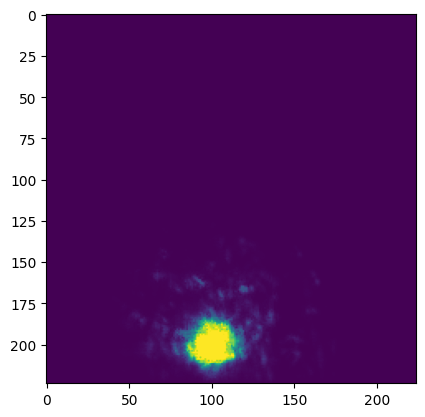

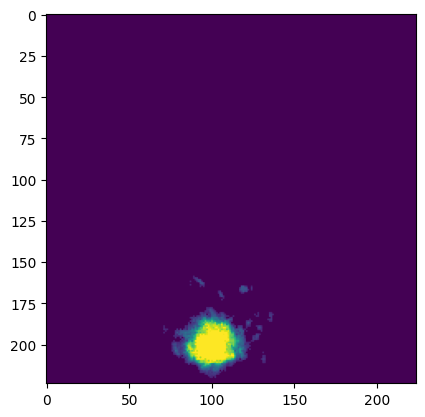

1417


In [38]:
average_grays = np.mean(concatenated_grays[:, :, 1:], axis=2)

%matplotlib inline
thresholded = (average_grays > 0.1) * average_grays
plt.imshow(average_grays)
plt.show()
plt.imshow(thresholded)
plt.show()
area = np.count_nonzero(thresholded)
print(area)

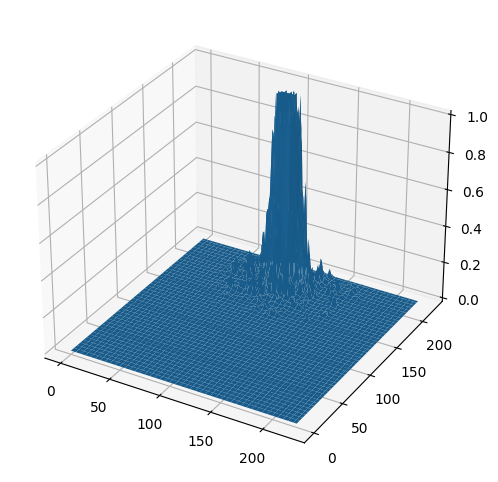

In [39]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
import numpy as np
#if using a Jupyter notebook, include:
%matplotlib inline
x = np.arange(0, 224, 1)
y = np.arange(0, 224, 1)
X,Y = np.meshgrid(x,y)
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, average_grays.squeeze())
plt.show()

Pixel 200, 100 small dataset average pooled representation

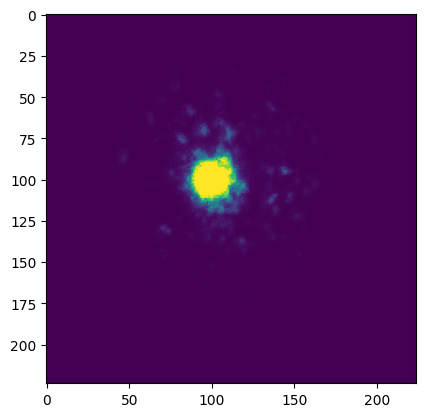

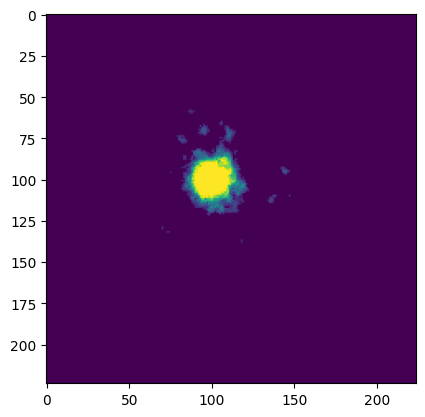

1380


In [41]:
average_grays = np.mean(concatenated_grays[:, :, 1:], axis=2)

%matplotlib inline
thresholded = (average_grays > 0.1) * average_grays
plt.imshow(average_grays)
plt.show()
plt.imshow(thresholded)
plt.show()
area = np.count_nonzero(thresholded)
print(area)

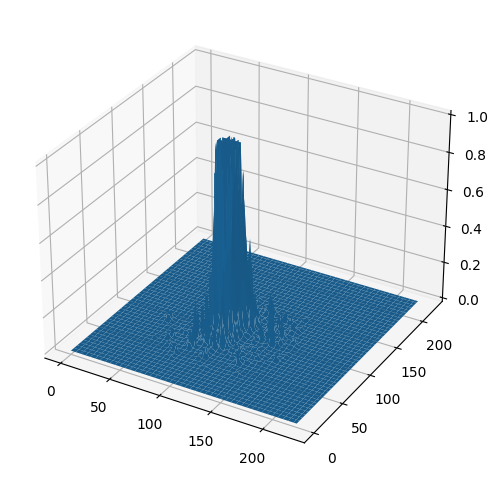

In [42]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
import numpy as np
#if using a Jupyter notebook, include:
%matplotlib inline
x = np.arange(0, 224, 1)
y = np.arange(0, 224, 1)
X,Y = np.meshgrid(x,y)
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, average_grays.squeeze())
plt.show()

Pixel 200, 100 Large dataset average pooled representation

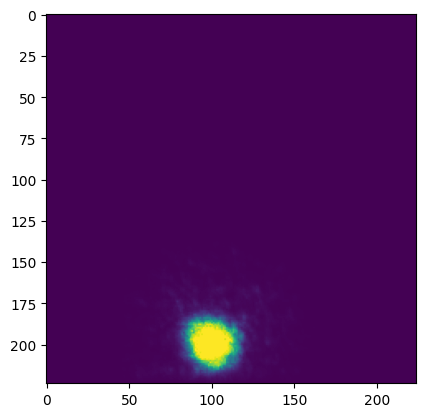

1300


In [45]:
average_grays = np.mean(concatenated_grays[:, :, 1:], axis=2)

%matplotlib inline
thresholded = (average_grays > 0.1) * average_grays
plt.imshow(average_grays)
plt.show()
# plt.imshow(thresholded)
# plt.show()
area = np.count_nonzero(thresholded)
print(area)

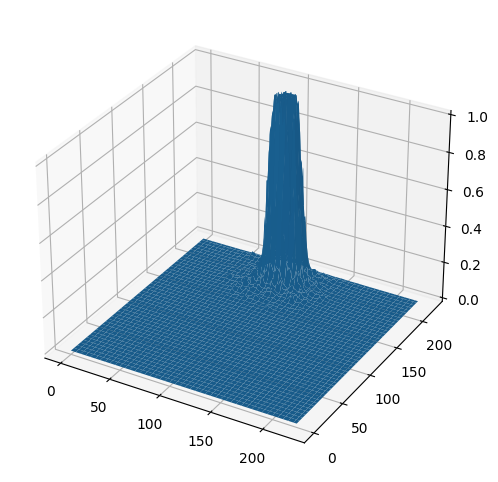

In [46]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
import numpy as np
#if using a Jupyter notebook, include:
%matplotlib inline
x = np.arange(0, 224, 1)
y = np.arange(0, 224, 1)
X,Y = np.meshgrid(x,y)
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, average_grays.squeeze())
plt.show()